In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score


In [67]:
df = pd.read_csv('/content/drive/MyDrive/פרויקט גמר/sp500_daily.csv')
df

,Price,Close,High,Low,Open,Volume
0,Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,3257.85009765625,3258.139892578125,3235.530029296875,3244.669921875,3459930000
3,2020-01-03,3234.85009765625,3246.14990234375,3222.340087890625,3226.360107421875,3484700000
4,2020-01-06,3246.280029296875,3246.840087890625,3214.639892578125,3217.550048828125,3702460000
...,...,...,...,...,...,...
1516,2026-01-12,6977.27001953125,6986.330078125,6934.06982421875,6944.1201171875,5019040000
1517,2026-01-13,6963.740234375,6985.830078125,6938.77001953125,6977.41015625,5091730000
1518,2026-01-14,6926.60009765625,6941.2998046875,6885.740234375,6937.41015625,5530830000
1519,2026-01-15,6944.47021484375,6979.33984375,6937.93017578125,6969.4599609375,5114050000


In [68]:
df.isna().any(axis=1).sum()

np.int64(1)

In [69]:
df = df.dropna()


In [70]:
df = df.drop(index=0).reset_index(drop=True)

In [71]:
df['Open_tomorrow'] = df['Open'].shift(-1)

In [72]:
df['Open_gt_Close'] = (df['Open_tomorrow'] > df['Close']).astype(int)

In [73]:
df['Close_gt_Open'] = (df['Close'] > df['Close'].shift(1)).astype(int)

In [74]:
df = df.dropna(subset=['Open_tomorrow'])

In [75]:
df

,Price,Close,High,Low,Open,Volume,Open_tomorrow,Open_gt_Close,Close_gt_Open
0,2020-01-02,3257.85009765625,3258.139892578125,3235.530029296875,3244.669921875,3459930000,3226.360107421875,0,0
1,2020-01-03,3234.85009765625,3246.14990234375,3222.340087890625,3226.360107421875,3484700000,3217.550048828125,0,0
2,2020-01-06,3246.280029296875,3246.840087890625,3214.639892578125,3217.550048828125,3702460000,3241.860107421875,0,1
3,2020-01-07,3237.179931640625,3244.909912109375,3232.429931640625,3241.860107421875,3435910000,3238.590087890625,1,0
4,2020-01-08,3253.050048828125,3267.070068359375,3236.669921875,3238.590087890625,3726840000,3266.030029296875,1,1
...,...,...,...,...,...,...,...,...,...
1513,2026-01-09,6966.27978515625,6978.35986328125,6917.64013671875,6927.830078125,5163900000,6944.1201171875,0,1
1514,2026-01-12,6977.27001953125,6986.330078125,6934.06982421875,6944.1201171875,5019040000,6977.41015625,1,1
1515,2026-01-13,6963.740234375,6985.830078125,6938.77001953125,6977.41015625,5091730000,6937.41015625,0,0
1516,2026-01-14,6926.60009765625,6941.2998046875,6885.740234375,6937.41015625,5530830000,6969.4599609375,1,0


In [76]:
df['Close_tomorrow'] = df['Close'].shift(-1)


In [174]:
k_days=13
test_size = 0.3
features = ["Volume","Open","High","Open_gt_Close"]
target = 'Close_gt_Open'


In [175]:
X = pd.concat([df[features].shift(i) for i in reversed(range(k_days))], axis=1)
X.columns = [f"{feat}_t-{i}" for i in reversed(range(k_days)) for feat in features]
y = df[target]

In [176]:
X = X.iloc[k_days-1:].reset_index(drop=True)
y = y.iloc[k_days-1:].reset_index(drop=True)

In [177]:
X_np = X.to_numpy().astype(float)
y_np = y.to_numpy().astype(int)

In [178]:
split_idx = int(len(X_np) * (1 - test_size))
X_train, X_test = X_np[:split_idx], X_np[split_idx:]
y_train, y_test = y_np[:split_idx], y_np[split_idx:]

In [179]:
print(X_train.shape,y_train.shape)

(1054, 52) (1054,)


In [180]:
print(X_test.shape,y_test.shape)

(452, 52) (452,)


In [84]:

# #Symmetry dont use
# counter = Counter(y_train)
# n_class_0 = counter[0]
# n_class_1 = counter[1]
# max_class = max(n_class_0, n_class_1)

# # יוצרים Train סימטרי ע"י שכפול בלוקים קטנים
# X_train_0 = X_train[y_train == 0]
# X_train_1 = X_train[y_train == 1]

# # שכפול
# X_train_0_up = np.tile(X_train_0, (int(np.ceil(max_class / len(X_train_0))), 1))[:max_class]
# X_train_1_up = np.tile(X_train_1, (int(np.ceil(max_class / len(X_train_1))), 1))[:max_class]

# y_train_0_up = np.zeros(max_class, dtype=int)
# y_train_1_up = np.ones(max_class, dtype=int)

# # מחברים חזרה
# X_train = np.vstack([X_train_0_up, X_train_1_up])
# y_train = np.concatenate([y_train_0_up, y_train_1_up])


In [181]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(496), np.int64(1): np.int64(558)}


In [183]:
counter = Counter(y_train)
weight = counter[0] / counter[1]
model = xgb.XGBClassifier(
    scale_pos_weight=weight  ,
    n_estimators=350,
    max_depth=6  ,
    learning_rate=0.02,
    # use_label_encoder=False,
     eval_metric='logloss'

)
 # Adjust y_train to match X_train's shape
X_train = X_train[:,:-1]

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, ...)

In [184]:
X_test = X_test[:,:-1]

In [185]:
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[116  75]
 [ 89 172]]
Accuracy: 0.6372


In [90]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.80      0.53       127
           1       0.46      0.13      0.20       175

    accuracy                           0.41       302
   macro avg       0.43      0.46      0.36       302
weighted avg       0.43      0.41      0.34       302



In [100]:
model.get_booster().feature_names = features

In [162]:
k_days = 13 # מספר הימים אחורה שאת בודקת

feature_names = []

# יצירת השמות עבור המערך
for col in features:
    feature_names.append(f"{col}_current") # הערך של היום
    for i in range(1, k_days ):
        feature_names.append(f"{col}_lag_{i}") # הערכים של ימי העבר
print(feature_names)

['Volume_current', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4', 'Volume_lag_5', 'Volume_lag_6', 'Volume_lag_7', 'Volume_lag_8', 'Volume_lag_9', 'Volume_lag_10', 'Volume_lag_11', 'Volume_lag_12', 'Open_current', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4', 'Open_lag_5', 'Open_lag_6', 'Open_lag_7', 'Open_lag_8', 'Open_lag_9', 'Open_lag_10', 'Open_lag_11', 'Open_lag_12', 'High_current', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4', 'High_lag_5', 'High_lag_6', 'High_lag_7', 'High_lag_8', 'High_lag_9', 'High_lag_10', 'High_lag_11', 'High_lag_12']


39


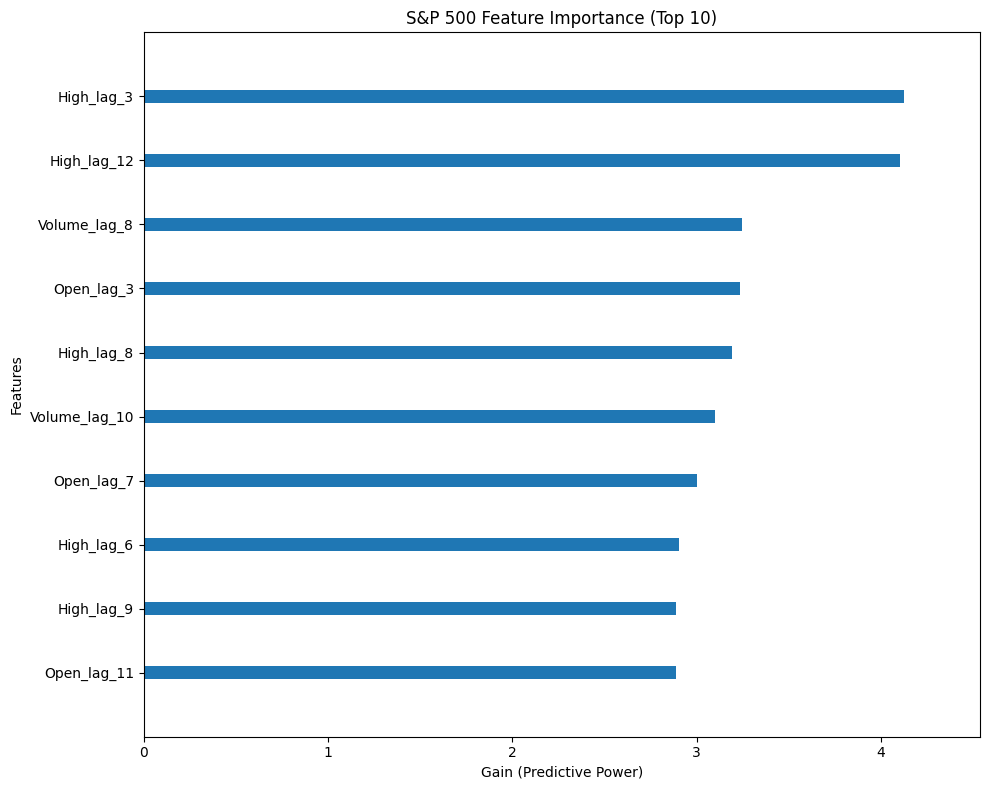

In [163]:

# X_train was sliced twice by [:,:-1], so remove the last two feature names
corrected_feature_names = feature_names
print (len(corrected_feature_names))
model.get_booster().feature_names = corrected_feature_names

# 2. הגדרת גודל הגרף (כדי שיהיה מקום לשמות ארוכים בצד)
plt.rcParams["figure.figsize"] = (10, 8)

# 3. יצירת גרף הבארים (Feature Importance)
# הערה: העברנו את ה-importance_type ל-'gain' כי הוא משמעותי יותר בחיזוי מניות
plot_importance(model,
                max_num_features=10, # נציג את ה-10 הכי חזקים מתוך הרשימה
                importance_type='gain',
                grid=False,
                show_values=False, # כדי שהגרף יהיה נקי
                title='S&P 500 Feature Importance (Top 10)',
                xlabel='Gain (Predictive Power)',
                ylabel='Features')

plt.tight_layout() # מבטיח שהשמות לא ייחתכו בשוליים
plt.show()
# k_days=13
# test_size = 0.2
# features = ["Volume","Open","High",]
# target = 'Close_gt_Open'

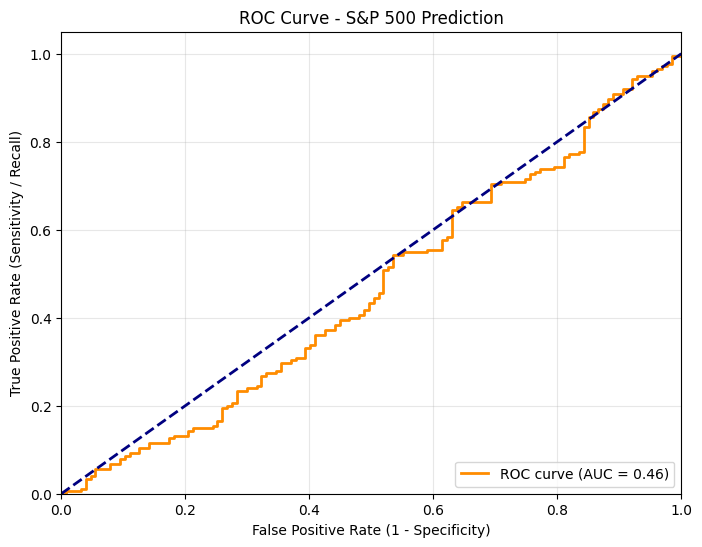

In [164]:

# 1. קבלת ההסתברויות מהמודל (הסתברות למחלקה 1 - עלייה)
y_probs = model.predict_proba(X_test)[:, 1]

# 2. חישוב נתוני ה-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_value = roc_auc_score(y_test, y_probs)

# 3. ציור הגרף
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # קו האלכסון (רנדומלי)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('ROC Curve - S&P 500 Prediction')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
# k_days=13
# test_size = 0.2
# features = ["Volume","Open","High",]
# target = 'Close_gt_Open'

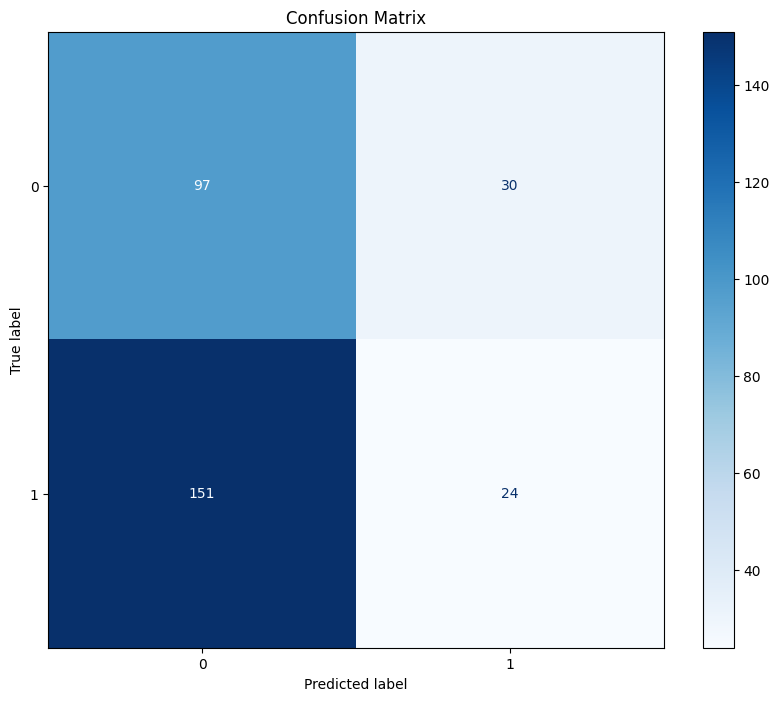

In [113]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# k_days=13
# test_size = 0.2
# features = ["Volume","Open","High",]
# target = 'Close_gt_Open'

In [ ]:
print(X_test.shape,y_test.shape)

In [ ]:
print(X_train.shape,y_train.shape)

In [151]:
k_days = 9 # מספר הימים אחורה שאת בודקת

feature_names = []

# יצירת השמות עבור המערך
for col in features:
    feature_names.append(f"{col}_current") # הערך של היום
    for i in range(1, k_days ):
        feature_names.append(f"{col}_lag_{i}") # הערכים של ימי העבר
print(feature_names)

['Open_current', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4', 'Open_lag_5', 'Open_lag_6', 'Open_lag_7', 'Open_lag_8', 'Volume_current', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4', 'Volume_lag_5', 'Volume_lag_6', 'Volume_lag_7', 'Volume_lag_8', 'High_current', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4', 'High_lag_5', 'High_lag_6', 'High_lag_7', 'High_lag_8']


27


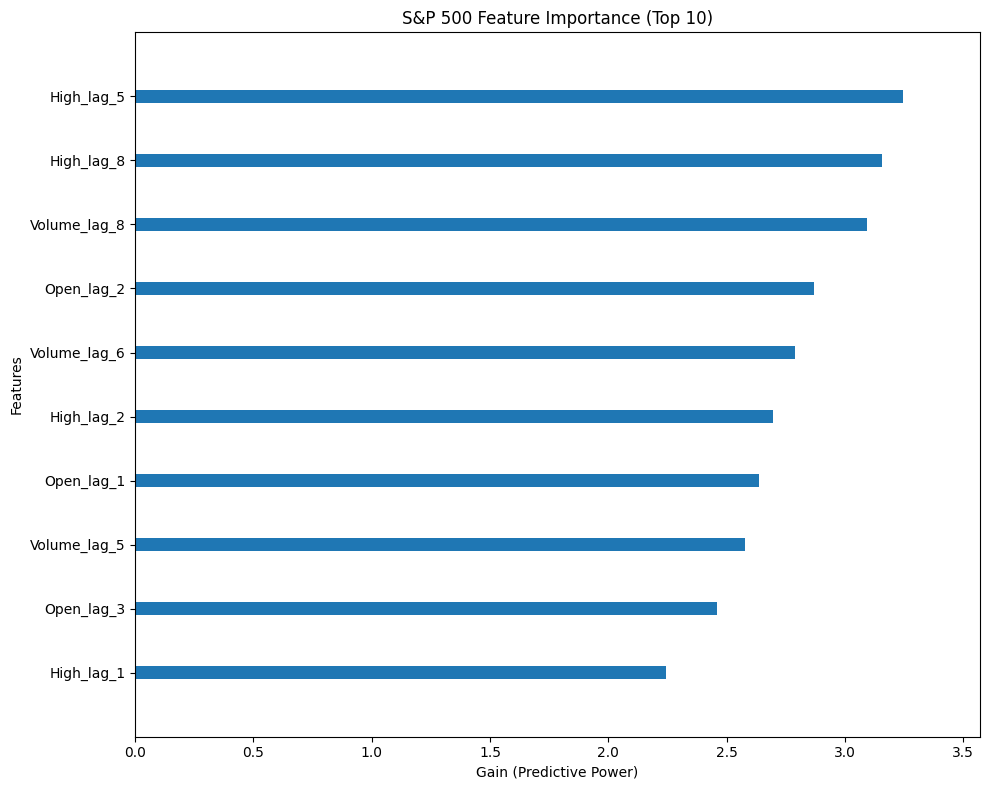

In [152]:
corrected_feature_names = feature_names
print (len(corrected_feature_names))
model.get_booster().feature_names = corrected_feature_names

# 2. הגדרת גודל הגרף (כדי שיהיה מקום לשמות ארוכים בצד)
plt.rcParams["figure.figsize"] = (10, 8)

# 3. יצירת גרף הבארים (Feature Importance)
# הערה: העברנו את ה-importance_type ל-'gain' כי הוא משמעותי יותר בחיזוי מניות
plot_importance(model,
                max_num_features=10, # נציג את ה-10 הכי חזקים מתוך הרשימה
                importance_type='gain',
                grid=False,
                show_values=False, # כדי שהגרף יהיה נקי
                title='S&P 500 Feature Importance (Top 10)',
                xlabel='Gain (Predictive Power)',
                ylabel='Features')

plt.tight_layout() # מבטיח שהשמות לא ייחתכו בשוליים
plt.show()

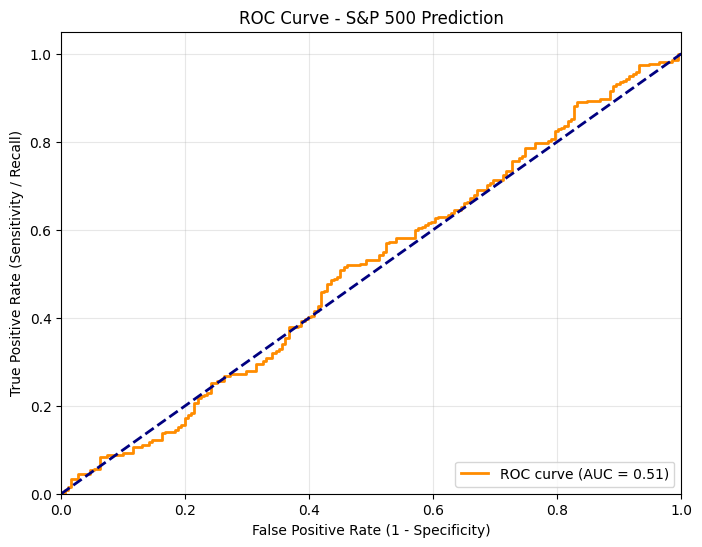

In [153]:
# k_days=9
# test_size = 0.3
# features = ["Volume","Open","High"]
# target = 'Close_gt_Open'
y_probs = model.predict_proba(X_test)[:, 1]

# 2. חישוב נתוני ה-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_value = roc_auc_score(y_test, y_probs)

# 3. ציור הגרף
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # קו האלכסון (רנדומלי)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('ROC Curve - S&P 500 Prediction')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

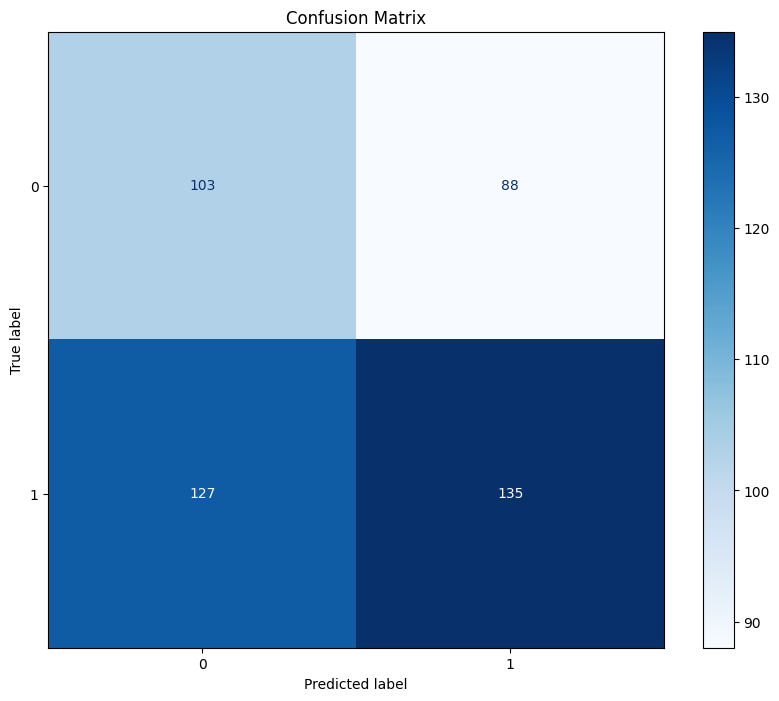

In [154]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# k_days=9
# test_size = 0.3
# features = ["Volume","Open","High"]
# target = 'Close_gt_Open'


In [188]:
k_days = 13 # מספר הימים אחורה שאת בודקת

feature_names = []

# יצירת השמות עבור המערך
for col in features:
    feature_names.append(f"{col}_current") # הערך של היום
    for i in range(1, k_days ):
        feature_names.append(f"{col}_lag_{i}") # הערכים של ימי העבר
print(feature_names)

['Volume_current', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4', 'Volume_lag_5', 'Volume_lag_6', 'Volume_lag_7', 'Volume_lag_8', 'Volume_lag_9', 'Volume_lag_10', 'Volume_lag_11', 'Volume_lag_12', 'Open_current', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4', 'Open_lag_5', 'Open_lag_6', 'Open_lag_7', 'Open_lag_8', 'Open_lag_9', 'Open_lag_10', 'Open_lag_11', 'Open_lag_12', 'High_current', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4', 'High_lag_5', 'High_lag_6', 'High_lag_7', 'High_lag_8', 'High_lag_9', 'High_lag_10', 'High_lag_11', 'High_lag_12', 'Open_gt_Close_current', 'Open_gt_Close_lag_1', 'Open_gt_Close_lag_2', 'Open_gt_Close_lag_3', 'Open_gt_Close_lag_4', 'Open_gt_Close_lag_5', 'Open_gt_Close_lag_6', 'Open_gt_Close_lag_7', 'Open_gt_Close_lag_8', 'Open_gt_Close_lag_9', 'Open_gt_Close_lag_10', 'Open_gt_Close_lag_11', 'Open_gt_Close_lag_12']


51


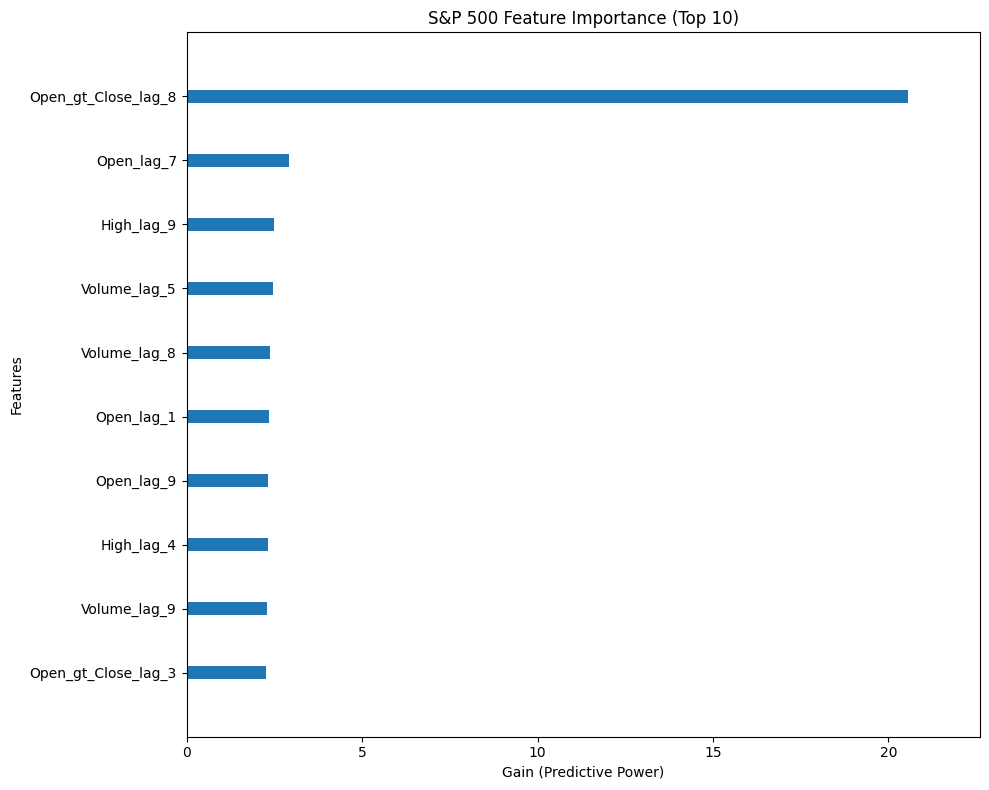

In [192]:
corrected_feature_names = feature_names[:-1]
print (len(corrected_feature_names))
model.get_booster().feature_names = corrected_feature_names

# 2. הגדרת גודל הגרף (כדי שיהיה מקום לשמות ארוכים בצד)
plt.rcParams["figure.figsize"] = (10, 8)

# 3. יצירת גרף הבארים (Feature Importance)
# הערה: העברנו את ה-importance_type ל-'gain' כי הוא משמעותי יותר בחיזוי מניות
plot_importance(model,
                max_num_features=10, # נציג את ה-10 הכי חזקים מתוך הרשימה
                importance_type='gain',
                grid=False,
                show_values=False, # כדי שהגרף יהיה נקי
                title='S&P 500 Feature Importance (Top 10)',
                xlabel='Gain (Predictive Power)',
                ylabel='Features')

plt.tight_layout() # מבטיח שהשמות לא ייחתכו בשוליים
plt.show()
# k_days=13
# test_size = 0.3
# features = ["Volume","Open","High","Open_gt_Close"]
# target = 'Close_gt_Open'

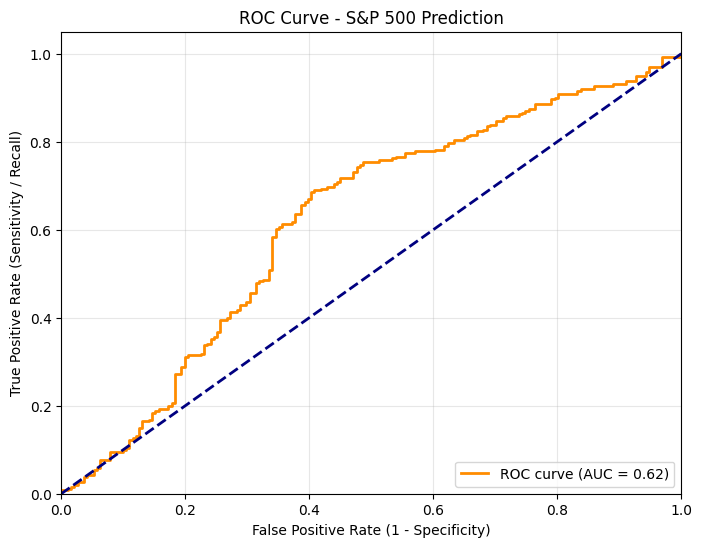

In [193]:
y_probs = model.predict_proba(X_test)[:, 1]

# 2. חישוב נתוני ה-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_value = roc_auc_score(y_test, y_probs)

# 3. ציור הגרף
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # קו האלכסון (רנדומלי)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('ROC Curve - S&P 500 Prediction')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
# k_days=13
# test_size = 0.3
# features = ["Volume","Open","High","Open_gt_Close"]
# target = 'Close_gt_Open'

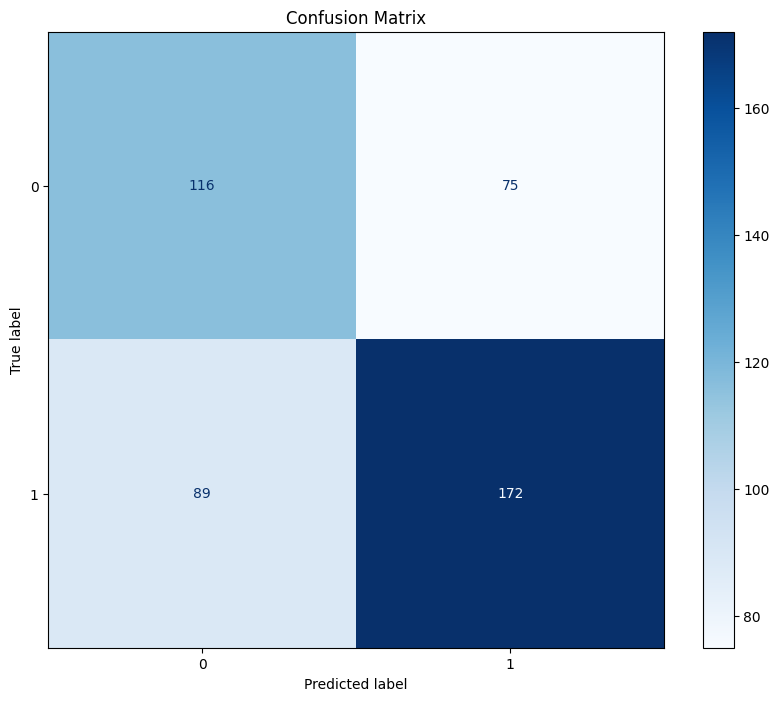

In [194]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# k_days=13
# test_size = 0.3
# features = ["Volume","Open","High","Open_gt_Close"]
# target = 'Close_gt_Open'

In [ ]:
# k_days=20
# test_size = 0.3
# features = ["Open","Volume"]
# target = 'Close_gt_Open'

# counter = Counter(y_train)
# weight = counter[0] / counter[1]
# model = xgb.XGBClassifier(
#     scale_pos_weight=weight,
#     n_estimators=350,
#     max_depth=6,
#     learning_rate=0.02,
#     # use_label_encoder=False,
#      eval_metric='logloss'

# )
# model.fit(X_train, y_train)
# Accuracy =0.5222

In [ ]:
# k_days=9
# test_size = 0.3
# features = ["Volume","Open","High"]
# target = 'Close_gt_Open'

# counter = Counter(y_train)
# weight = counter[0] / counter[1]
# model = xgb.XGBClassifier(
#     scale_pos_weight=weight,
#     n_estimators=350,
#     max_depth=6,
#     learning_rate=0.02,
#     # use_label_encoder=False,
#      eval_metric='logloss'

# )
# model.fit(X_train, y_train)
# Accuracy=0.5254

In [ ]:
# k_days=13
# test_size = 0.3
# features = ["Volume","Open","High","Open_gt_Close"]
# target = 'Close_gt_Open'

# counter = Counter(y_train)
# weight = counter[0] / counter[1]
# model = xgb.XGBClassifier(
#     scale_pos_weight=weight  ,#344 6 0.02,
#     n_estimators=344,
#     max_depth=6  ,
#     learning_rate=0.02,
#     # use_label_encoder=False,
#      eval_metric='logloss'

# )
#  # Adjust y_train to match X_train's shape
# X_train = X_train[:,:-1]
# # y_train = y_train[:-1]
# model.fit(X_train, y_train)